# Question 1: Weighting for Covariate Balance
---

1. Apply propensity score weighting to adjust for potential confounders when
comparing exposure groups. Discuss the rationale behind using propensity
scores to create comparable groups and mitigate selection bias in observational
studies.

2. Visualize the balance of propensity scores between exposure groups using
density plots, reflecting on how effective the weighting procedure has been in
adjusting the groups

## Step 0: Install the necessary packages and load them
---

In [62]:
install.packages("dplyr")
install.packages("fastDummies")
install.packages("tableone")
install.packages("MatchIt")
install.packages("survey")  # For weighting analysis
install.packages("cobalt")
install.packages("WeightIt")
install.packages("ggplot2")
install.packages("patchwork")
install.packages("cowplot")


The downloaded binary packages are in
	/var/folders/nv/sjj_9gb52674c8ktybqghkm80000gq/T//RtmpV8OHw6/downloaded_packages

The downloaded binary packages are in
	/var/folders/nv/sjj_9gb52674c8ktybqghkm80000gq/T//RtmpV8OHw6/downloaded_packages

The downloaded binary packages are in
	/var/folders/nv/sjj_9gb52674c8ktybqghkm80000gq/T//RtmpV8OHw6/downloaded_packages

The downloaded binary packages are in
	/var/folders/nv/sjj_9gb52674c8ktybqghkm80000gq/T//RtmpV8OHw6/downloaded_packages

The downloaded binary packages are in
	/var/folders/nv/sjj_9gb52674c8ktybqghkm80000gq/T//RtmpV8OHw6/downloaded_packages

The downloaded binary packages are in
	/var/folders/nv/sjj_9gb52674c8ktybqghkm80000gq/T//RtmpV8OHw6/downloaded_packages

The downloaded binary packages are in
	/var/folders/nv/sjj_9gb52674c8ktybqghkm80000gq/T//RtmpV8OHw6/downloaded_packages

The downloaded binary packages are in
	/var/folders/nv/sjj_9gb52674c8ktybqghkm80000gq/T//RtmpV8OHw6/downloaded_packages

The downloaded binary packages 

In [63]:
library(dplyr)
library(fastDummies)
library(tableone)
library(MatchIt)
library(survey)
library(cobalt)
library(WeightIt)
library(ggplot2)
library(ggplot2)
library(patchwork)
library(cowplot)


Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots




## Step 1: Load the dataset
---

In [64]:
load("cleaned_data.RData")

## Step 2: Check the content of the data
---

In [65]:
ls()

[1] "Df_regression_unique" "bal"                  "cov"                 
[4] "covariates"           "propensity_model"     "weightit_obj"

## Step 3: Check the class of the data
---

In [66]:
class(Df_regression_unique)

[1] "data.frame"

## Step 4: Calculate Propensity Scores
---

Define a logistic regression model for the propensity scores, using covariates (potential confounders) to predict group membership (exposure)


In [67]:
tail(Df_regression_unique)

,label,C-424144002,C-263495000,C-72166-2,C-763302001,C-39156-5,Followup,Exposure,asian,white,black,hawaiian
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5933,0,53,1,0,1,29.66,822,0,0,1,0,0
5934,0,70,0,0,1,30.06,3042,0,0,1,0,0
5935,0,70,0,0,1,31.07,1233,0,0,0,1,0
5936,1,75,0,0,1,29.60,1838,0,0,1,0,0
5937,0,59,0,0,1,27.30,2374,1,0,1,0,0
5938,0,46,1,0,1,27.60,356,0,0,1,0,0


In [68]:
# Fit a propensity score model
propensity_model <- glm(`Exposure` ~ `label` + `C-424144002` +`C-263495000` +`C-72166-2` +`C-763302001`+ `C-39156-5` + `Followup` + `asian` +`white` +`black` +`hawaiian`, 
                        family = binomial, 
                        data = Df_regression_unique)

In [69]:
# Extract propensity scores
Df_regression_unique$propensity_score <- predict(propensity_model, type = "response")

## Step 5: Plot the propensity score of each patient along with weights
---

In [70]:
tail(Df_regression_unique)

,label,C-424144002,C-263495000,C-72166-2,C-763302001,C-39156-5,Followup,Exposure,asian,white,black,hawaiian,propensity_score
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5933,0,53,1,0,1,29.66,822,0,0,1,0,0,0.1467727
5934,0,70,0,0,1,30.06,3042,0,0,1,0,0,0.1849143
5935,0,70,0,0,1,31.07,1233,0,0,0,1,0,0.1713956
5936,1,75,0,0,1,29.60,1838,0,0,1,0,0,0.2167486
5937,0,59,0,0,1,27.30,2374,1,0,1,0,0,0.2527476
5938,0,46,1,0,1,27.60,356,0,0,1,0,0,0.1826839


## Step 6: Check the summary of the model
---

In [71]:
summary(propensity_model)


Call:
glm(formula = Exposure ~ label + `C-424144002` + `C-263495000` + 
    `C-72166-2` + `C-763302001` + `C-39156-5` + Followup + asian + 
    white + black + hawaiian, family = binomial, data = Df_regression_unique)

Coefficients: (1 not defined because of singularities)
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)    1.338e+00  6.760e-01   1.979   0.0478 *  
label          3.463e-01  7.691e-02   4.502 6.72e-06 ***
`C-424144002` -3.013e-02  4.367e-03  -6.900 5.20e-12 ***
`C-263495000` -7.829e-01  8.773e-02  -8.924  < 2e-16 ***
`C-72166-2`           NA         NA      NA       NA    
`C-763302001` -7.118e-02  8.584e-02  -0.829   0.4070    
`C-39156-5`   -2.642e-02  1.765e-02  -1.497   0.1343    
Followup       7.517e-06  3.293e-05   0.228   0.8194    
asian          1.798e-01  3.107e-01   0.579   0.5627    
white          1.306e-01  2.893e-01   0.452   0.6516    
black          7.855e-02  3.100e-01   0.253   0.8000    
hawaiian      -2.454e-02  4.530e-01  -0.0

## Step 7: Create Propensity Score Weights
---

Calculate inverse probability of treatment weights (IPTW)

In [72]:
# Create weights
Df_regression_unique$weights <- ifelse(Df_regression_unique$Exposure == 1, 
                                       1 / Df_regression_unique$propensity_score, 
                                       1 / (1 - Df_regression_unique$propensity_score))

In [74]:
tail(Df_regression_unique)

,label,C-424144002,C-263495000,C-72166-2,C-763302001,C-39156-5,Followup,Exposure,asian,white,black,hawaiian,propensity_score,weights
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5933,0,53,1,0,1,29.66,822,0,0,1,0,0,0.1467727,1.172021
5934,0,70,0,0,1,30.06,3042,0,0,1,0,0,0.1849143,1.226865
5935,0,70,0,0,1,31.07,1233,0,0,0,1,0,0.1713956,1.206849
5936,1,75,0,0,1,29.60,1838,0,0,1,0,0,0.2167486,1.276729
5937,0,59,0,0,1,27.30,2374,1,0,1,0,0,0.2527476,3.956516
5938,0,46,1,0,1,27.60,356,0,0,1,0,0,0.1826839,1.223517


## Step 8: Check Balance After Weighting
---
Assess whether covariates are balanced across exposure groups using weights. You can use standardized mean differences (SMD) or plot covariate balance.

In [95]:
# Extract covariates
covariates <- Df_regression_unique[, c("label", "C-424144002", "C-263495000", 
                                       "C-72166-2", "C-763302001", "C-39156-5", 
                                       "Followup", "asian", "white", "black", 
                                       "hawaiian")]

# Assess balance using data frame
bal <- bal.tab(
  x = covariates,
  treat = Df_regression_unique$Exposure,
  weights = Df_regression_unique$weights,un = TRUE
)

# Print balance summary
print(bal)

Note: `s.d.denom` not specified; assuming "pooled".


Balance Measures
               Type Diff.Un Diff.Adj
label        Binary  0.0846   0.0075
C-424144002 Contin. -0.0465   0.0088
C-263495000  Binary -0.1282  -0.0239
C-72166-2    Binary  0.0000   0.0000
C-763302001  Binary -0.0252  -0.0039
C-39156-5   Contin. -0.0560   0.0073
Followup    Contin.  0.0600  -0.0130
asian        Binary  0.0027  -0.0010
white        Binary  0.0093  -0.0008
black        Binary -0.0078   0.0012
hawaiian     Binary -0.0021   0.0005

Effective sample sizes
           Control Treated
Unadjusted 4754.   1182.  
Adjusted   4724.88 1078.53


## Step 9: Visualize the result
---

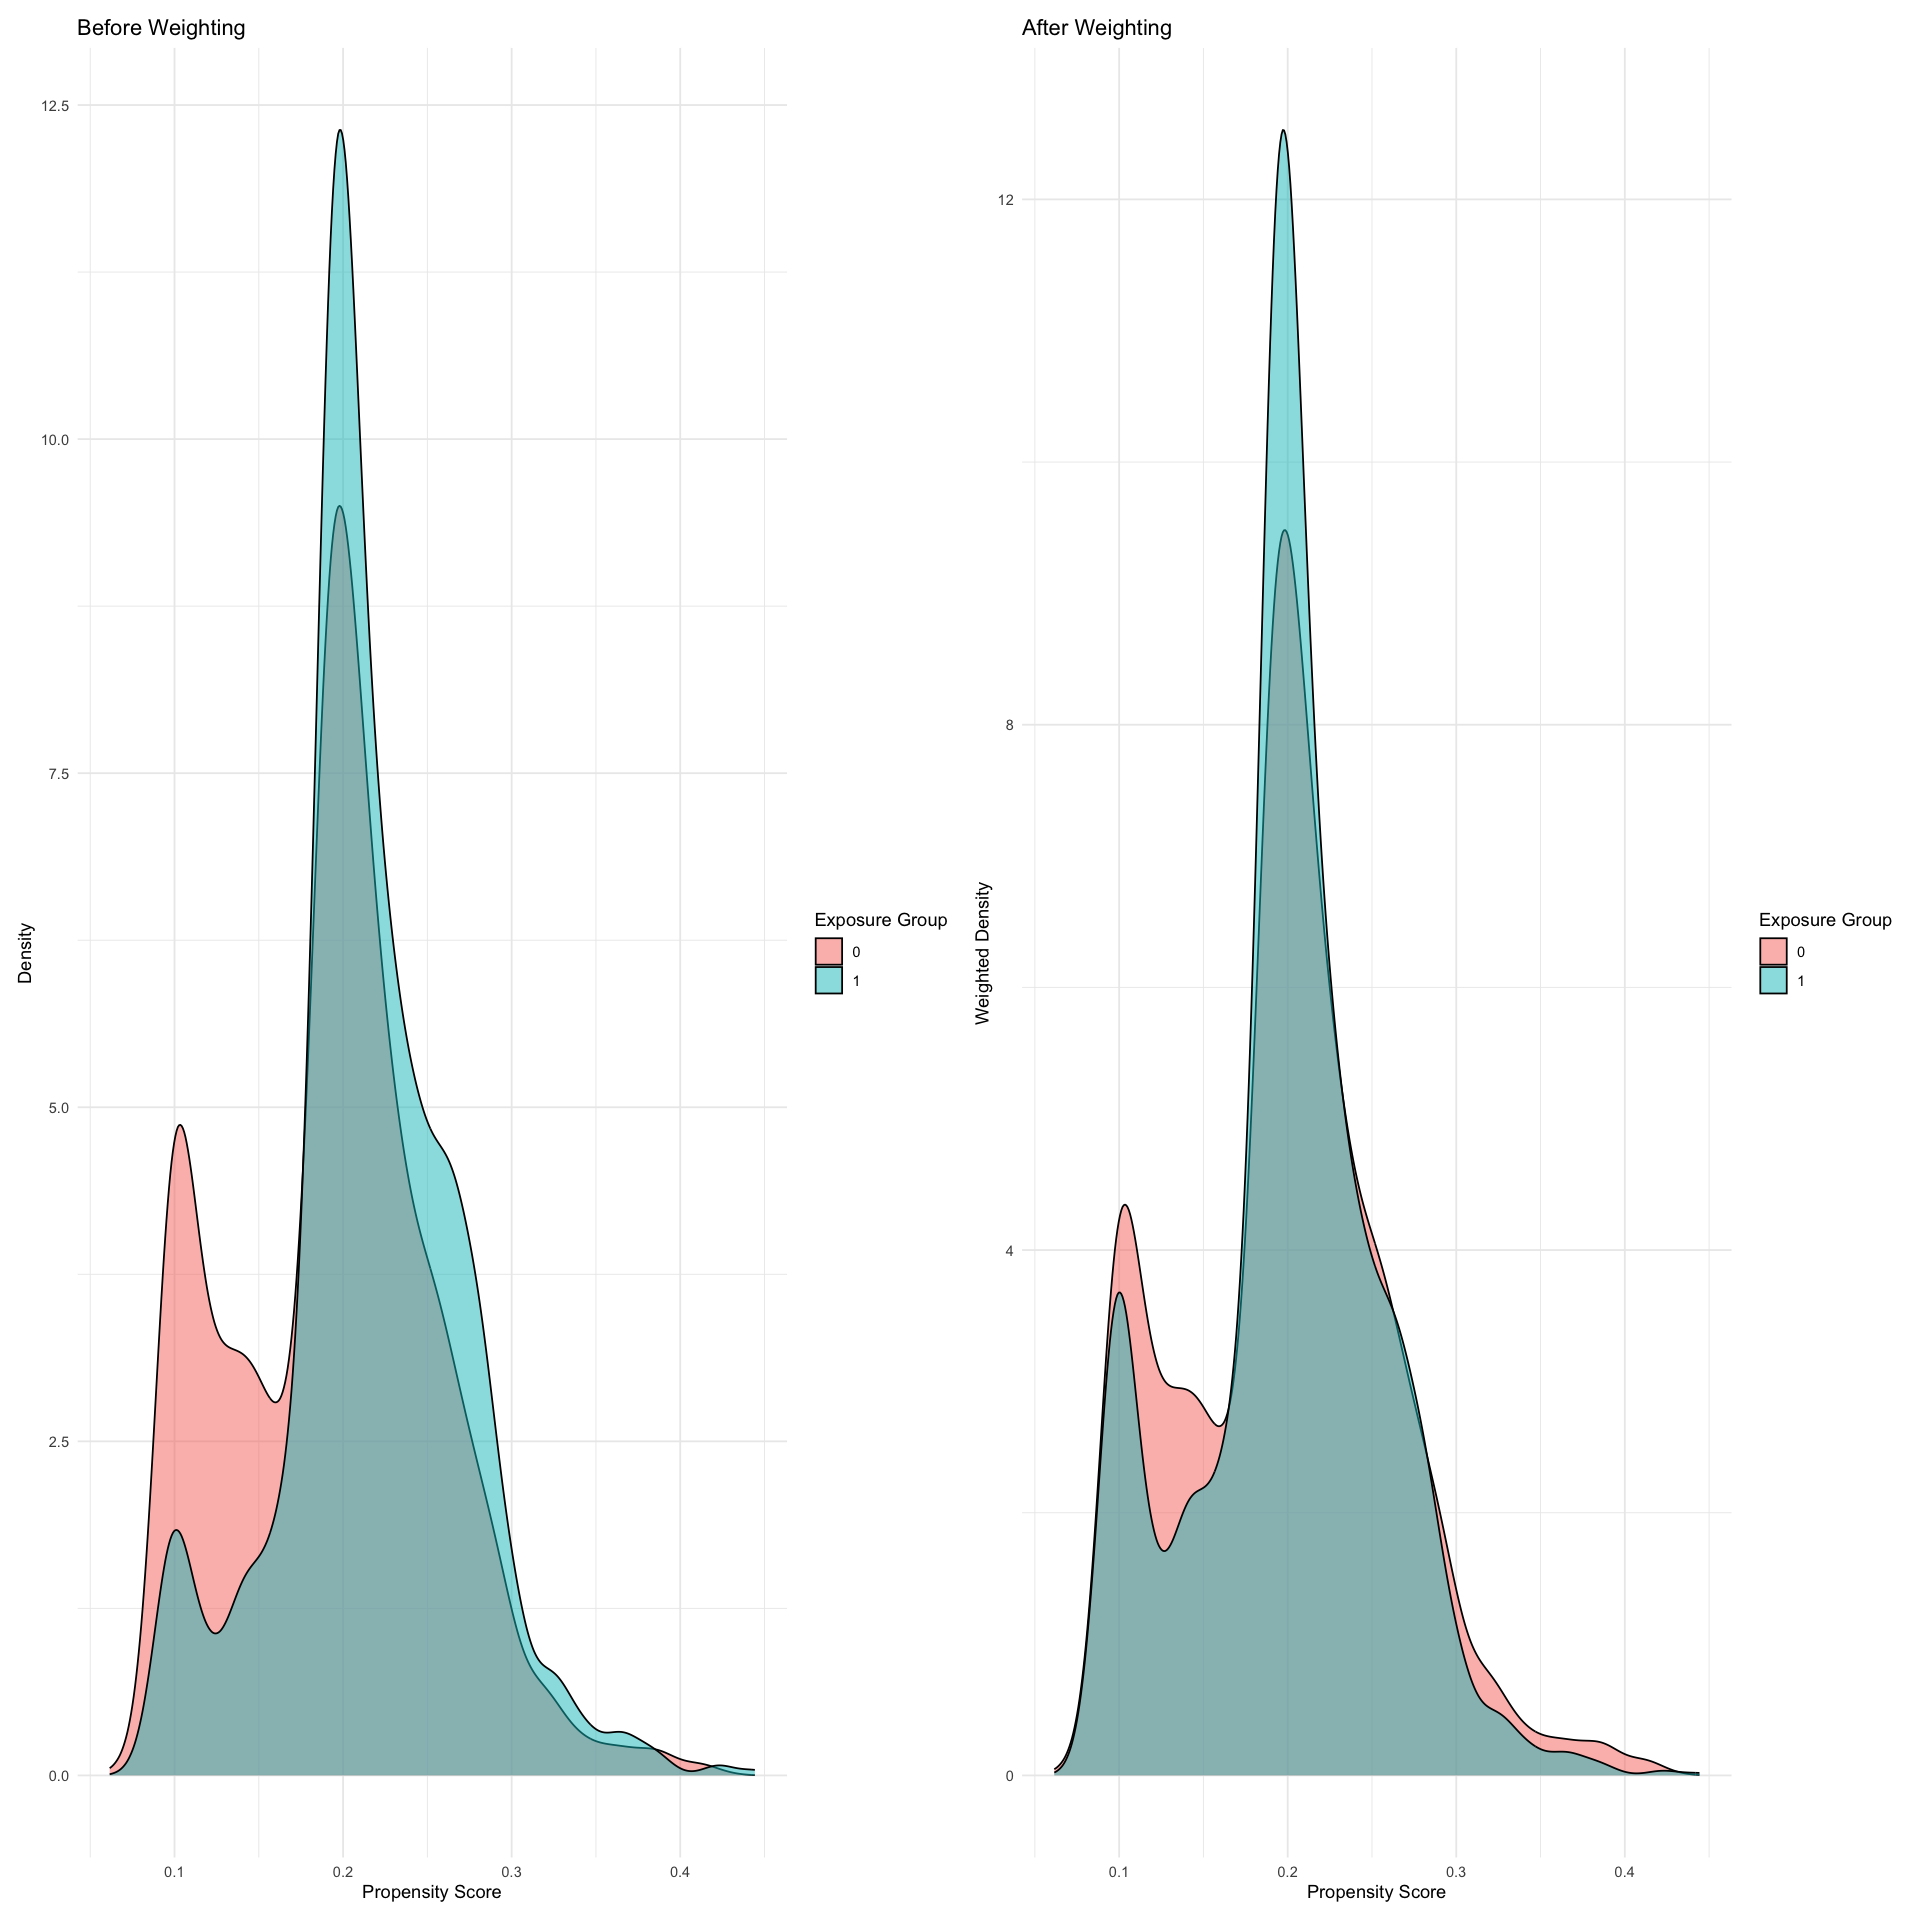

In [94]:
# Resize display for interactive use
options(repr.plot.width = 16, repr.plot.height = 16)

# Plot before weighting
plot_before <- ggplot(Df_regression_unique, aes(x = propensity_score, fill = as.factor(Exposure))) +
  geom_density(alpha = 0.5) +
  labs(title = "Before Weighting", x = "Propensity Score", y = "Density", fill = "Exposure Group") +
  theme_minimal()

# Plot after weighting
plot_after <- ggplot(Df_regression_unique, aes(x = propensity_score, weight = weights, fill = as.factor(Exposure))) +
  geom_density(alpha = 0.5) +
  labs(title = "After Weighting", x = "Propensity Score", y = "Weighted Density", fill = "Exposure Group") +
  theme_minimal()

# Combine plots side by side
combined_plot <- plot_before + plot_after

# Display the combined plot
combined_plot

# Save the combined plot
ggsave("combined_propensity_plots.png", plot = combined_plot, width = 12, height = 6, dpi = 300)


## Discussion
---
Propensity score methods are widely used in observational studies to address selection bias and confounding, particularly when randomized controlled trials (RCTs) are not feasible. Propensity scores estimate the probability of treatment (or exposure) assignment given observed covariates, enabling the creation of comparable groups.

## Key Concepts
---

### 1. Selection Bias:

In observational studies, treatment (or exposure) assignment is not random and may depend on patient or study characteristics.
Example: Smokers and non-smokers might differ systematically in age, socioeconomic status, or health conditions, which could confound the relationship between smoking and disease outcomes.

### 2. Confounding:

Confounders are variables related to both the exposure and the outcome that can distort the observed relationship.
Example: Age is both a determinant of smoking and a risk factor for heart disease.

### 3. Propensity Score Definition:

The propensity score is the conditional probability of being exposed to a treatment given a set of observed covariates:
 \begin{equation}
 e(X)= P \left( T = 1 | X\right)
 \end{equation}


Where : $\text{T}$ is the treatment indicator (1 = treated, 0 = untreated) and $\text{X}$ represents observed covariates.

## Rationale for Using Propensity Scores
---

### 1. Creating Comparable Groups

Propensity scores balance the distribution of observed covariates between treated and untreated groups, mimicking randomization. After adjustment, differences in outcomes can be more confidently attributed to the exposure rather than confounders.

### 2. Mitigating Selection Bias

By balancing observed covariates, propensity scores reduce selection bias due to systematic differences in treatment assignment.

### 3. Simplifying Multivariate Adjustment

Instead of adjusting for numerous covariates directly, propensity scores summarize the confounding information into a single scalar. This is particularly useful when dealing with many covariates or complex relationships.

### 4. Handling Covariate Imbalances
Propensity score methods ensure that treated and untreated groups are balanced with respect to observed covariates.
This reduces the risk of bias in estimating treatment effects.

### 5. Flexibility in Application

Propensity scores can be used with various methods, including:
- Matching: Pairing individuals with similar scores.
- Weighting: Applying inverse probability of treatment weights (IPTW).
- Stratification: Dividing the dataset into strata based on propensity scores.
- Covariate Adjustment: Including the propensity score as a covariate in regression models.

### 6. Transparency and Interpretability
Propensity scores allow researchers to visually and statistically assess balance across covariates using metrics like standardized mean differences or balance plots.
This provides clear evidence of how well the adjustment mitigates confounding.

## Effectiveness of Propensity Scores
---

### 1. Well-Balanced Covariates:

If propensity scores are correctly specified, covariates should be balanced across exposure groups after adjustment, ensuring comparability.

### 2. Reduces Bias from Observed Confounders:

Propensity scores account for observed confounders but cannot adjust for unmeasured confounding.


### 3. Avoids Model Overfitting:

By summarizing covariates into a single score, propensity scores reduce the risk of overfitting, especially in small samples.


## Limitations
---

### 1. Unmeasured Confounding:

Propensity scores only adjust for observed confounders. Bias due to unmeasured or unknown confounders may persist.


### 2. Positivity Violation:

Propensity score methods require overlap between treatment groups. If some covariate combinations only occur in one group, estimates may be unstable.


### 3. Dependence on Model Specification:

The quality of propensity score adjustment depends on correctly modeling the probability of treatment assignment.


### 4. No Replacement for Randomization:

Propensity scores mimic randomization for observed variables but cannot replicate the control over unobserved variables achieved in RCTs.

# Question 2: Love Plot for Covariate Balance
---

Implement a function that generates a Love plot to evaluate the balance of
covariates before and after applying propensity score weighting. Interpret the
plot and assess how well the weighting has succeeded in achieving balance
across the covariates.


## Step 8: Create Love plot
---

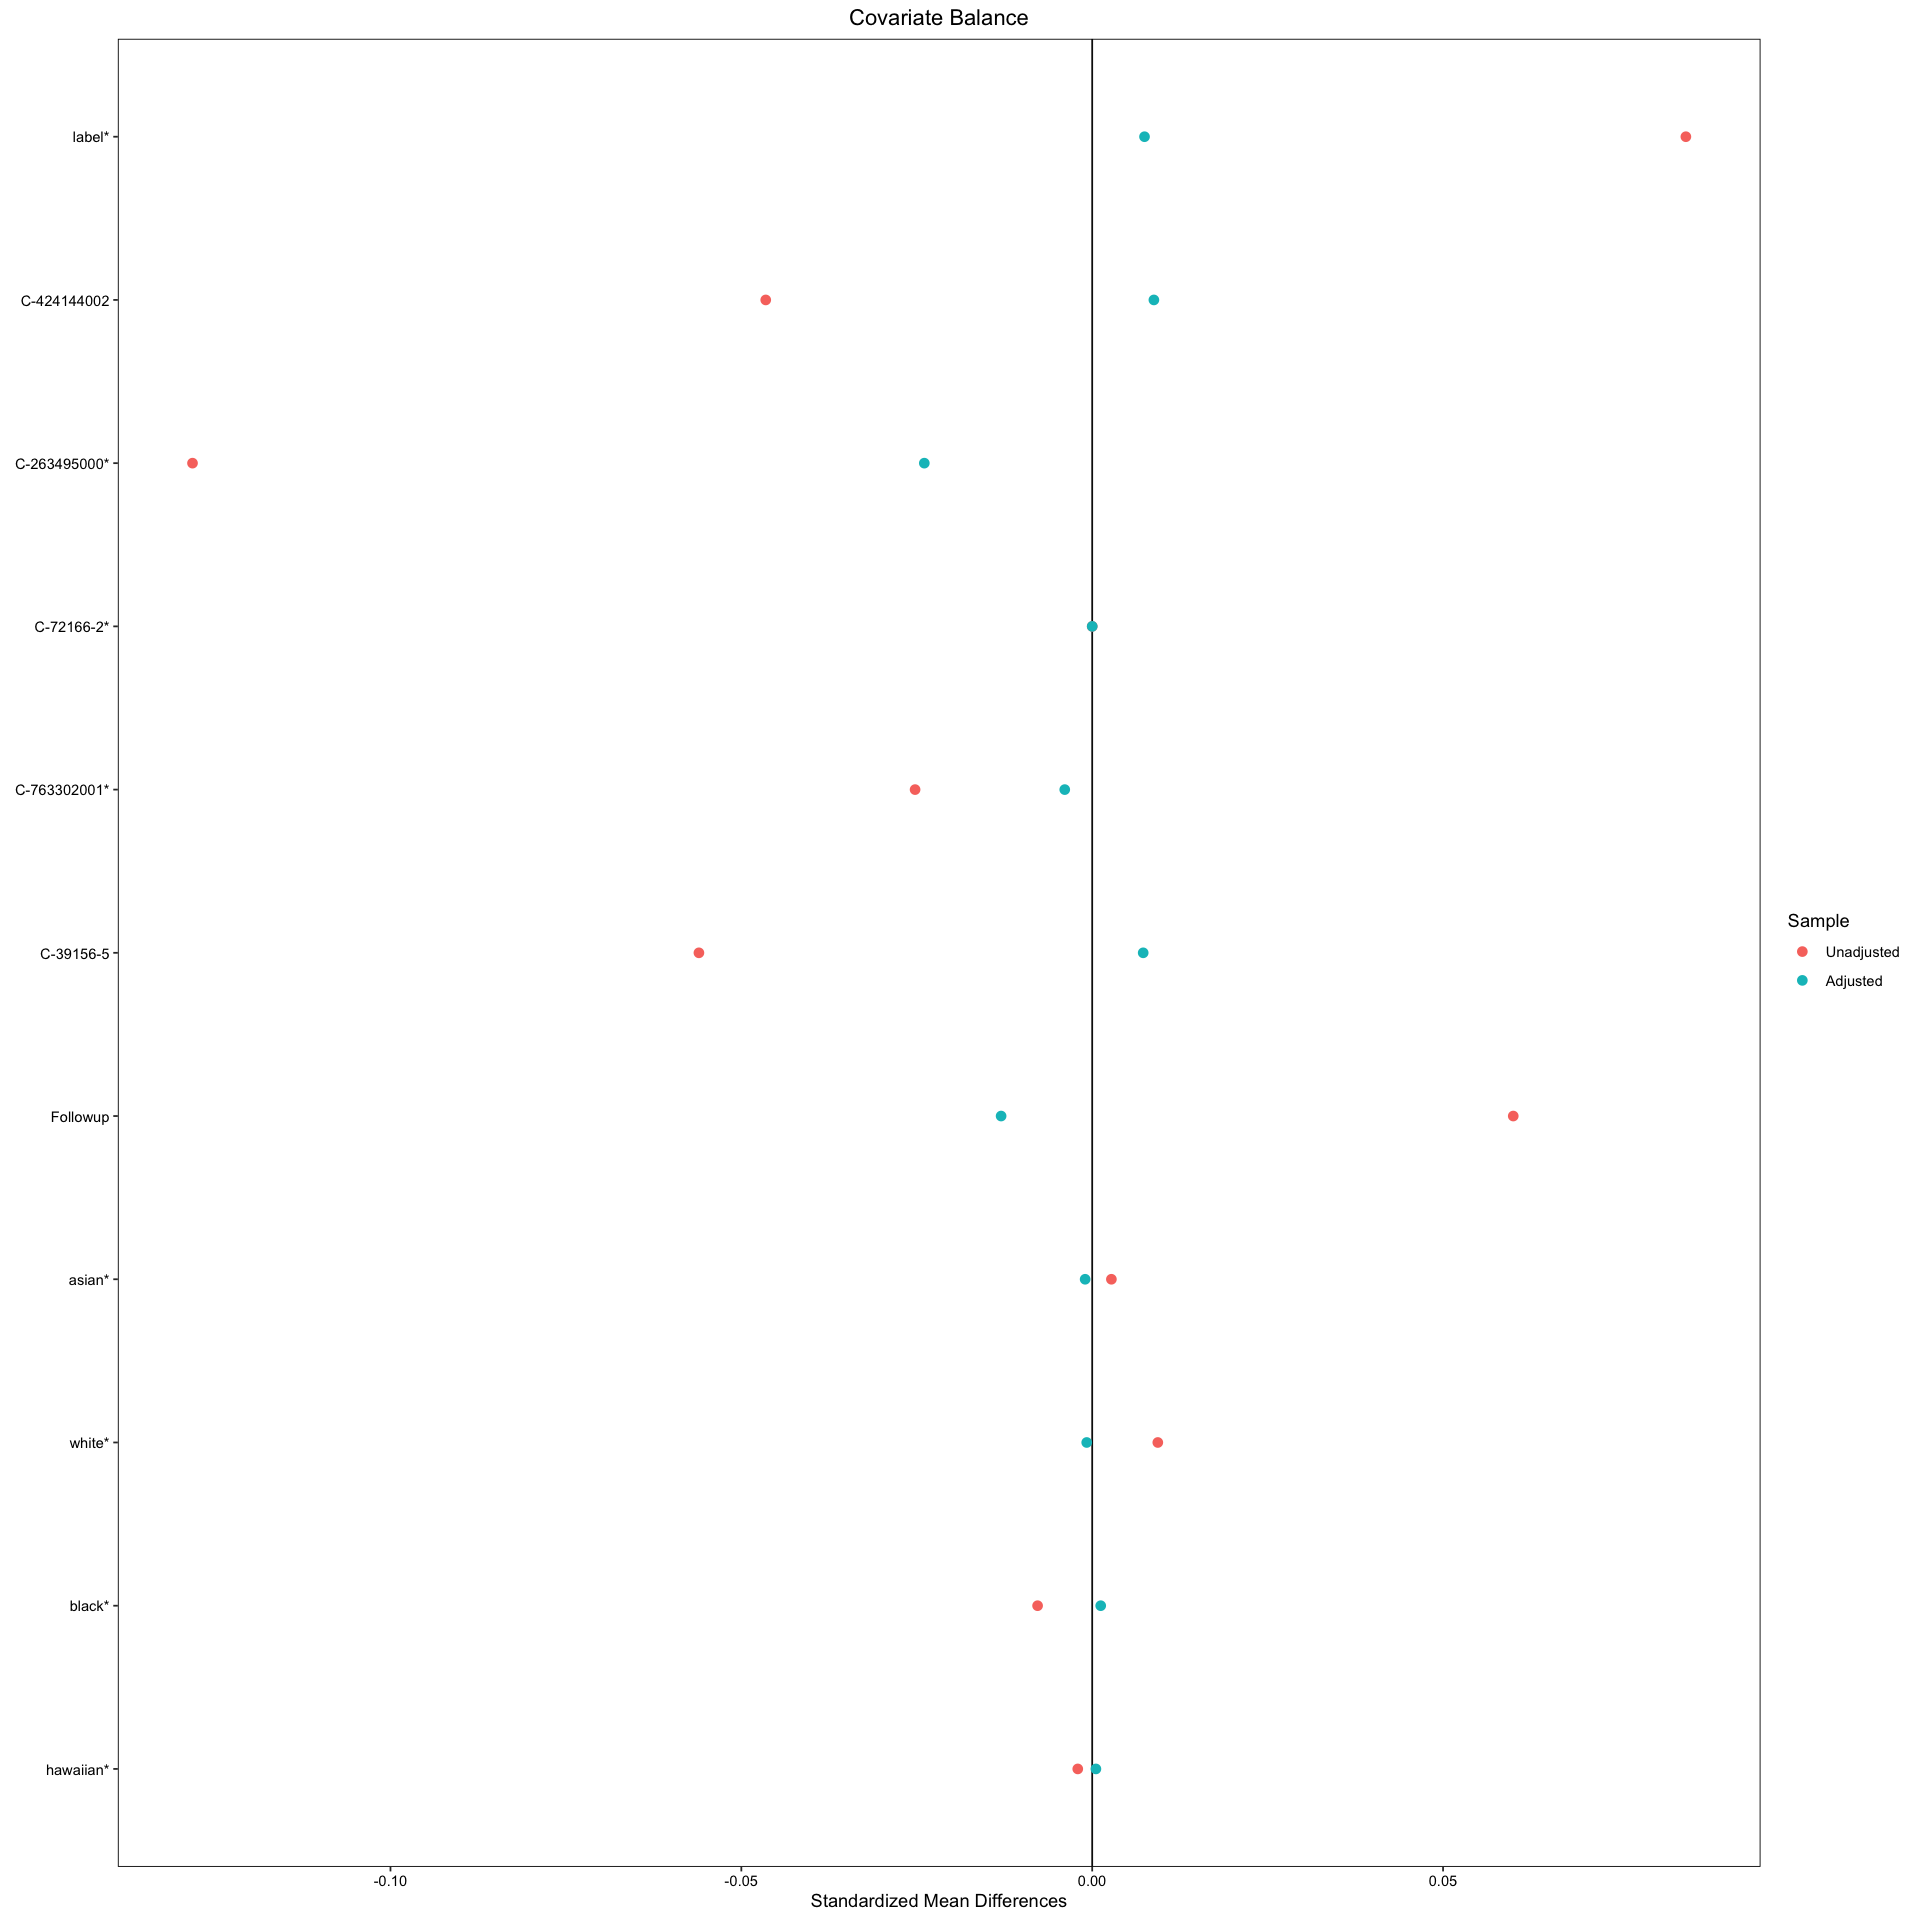

In [98]:
# Create a love plot with appropriate labels
love.plot(
  bal,
  stars = "raw",  # Highlight raw mean differences
  abs = FALSE      # Use absolute values for standardized mean differences
)

List of 3
 $ axis.title:List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : num 16
  ..$ hjust        : NULL
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 $ axis.text :List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : num 14
  ..$ hjust        : NULL
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 $ plot.title:List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : num 18
  ..$ hjust        : num 0.5
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : N

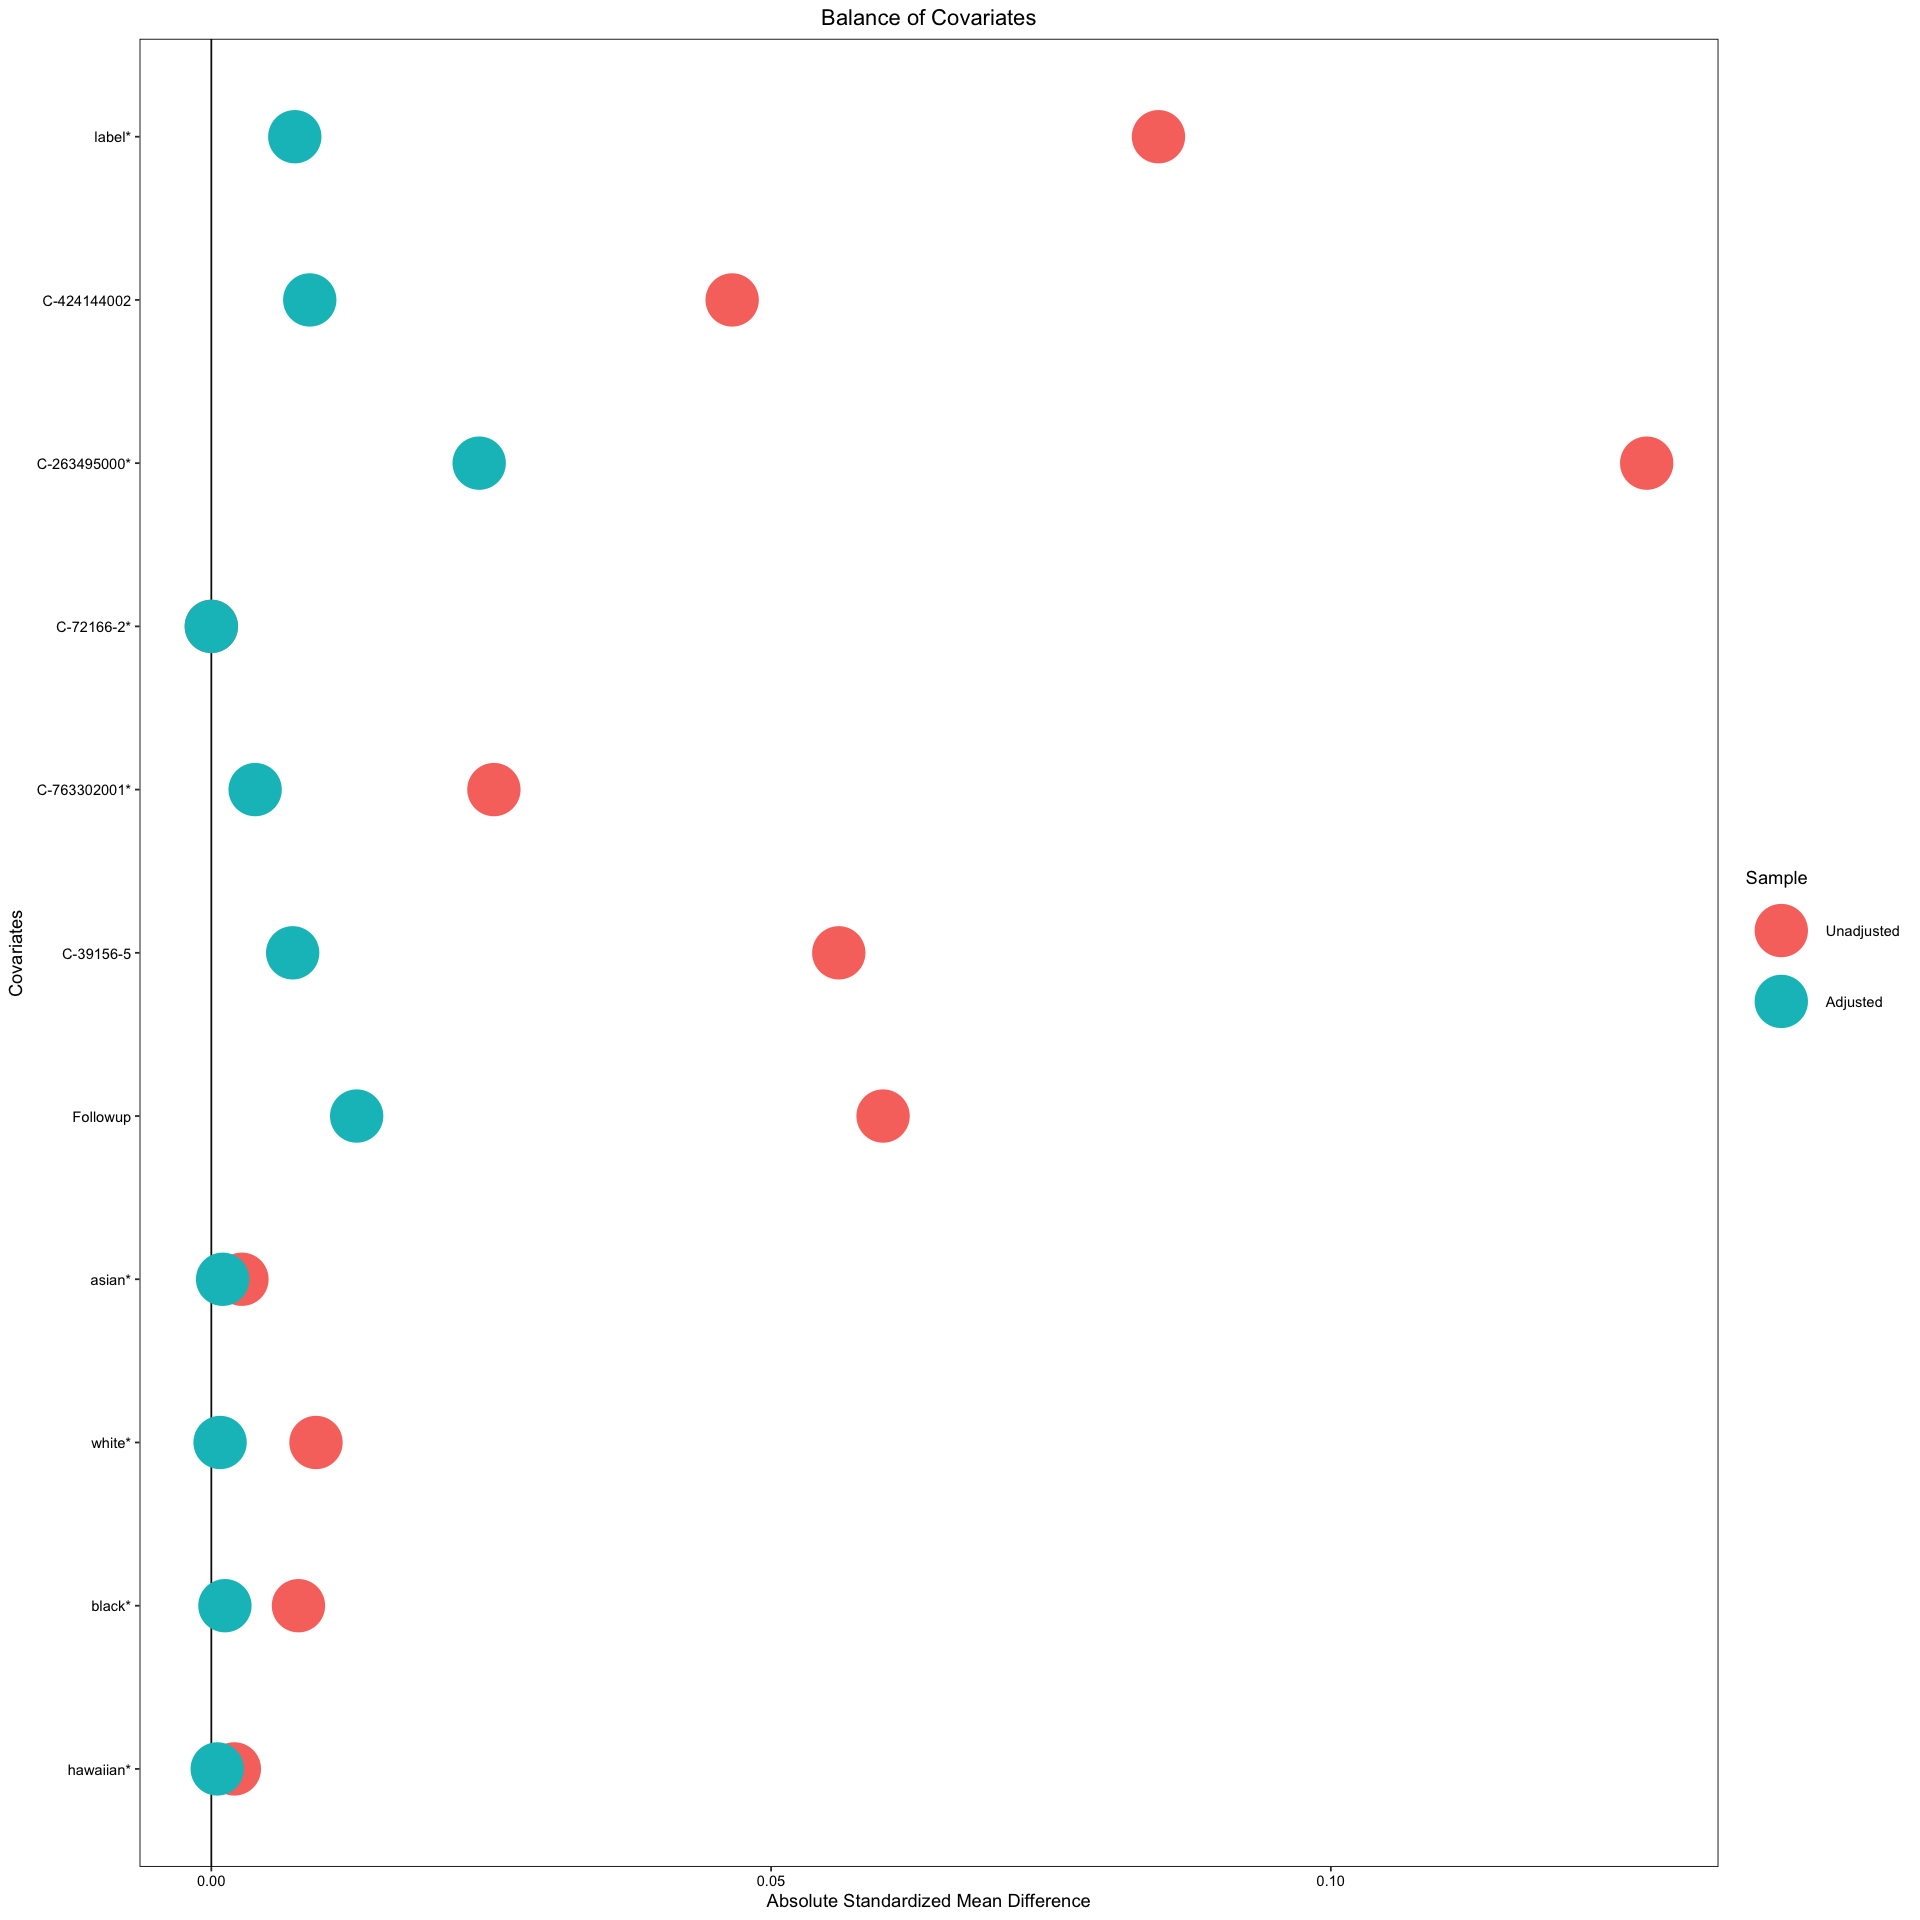

In [103]:
love.plot(
  bal,
  size = 15,
  text.size = 100,
  legend.size = 20,
    stars="raw",
  abs = TRUE
) +
labs(
  title = "Balance of Covariates",
  x = "Absolute Standardized Mean Difference",
  y = "Covariates"
)
theme(
  axis.text = element_text(size = 14),      # Axis text size
  axis.title = element_text(size = 16),     # Axis title size
  plot.title = element_text(size = 18, hjust = 0.5)  # Centered title
)